# Milestone 3 - Regression Simulation 

## Author - Aeden Jameson



## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

## Setup to Run This Notebook  

In order to run the code in this notebook you must install the Python pmdariama package which is not part of the standard Anaconda distribution. Follow these instructions to [pip install](https://alkaline-ml.com/pmdarima/setup.html#setup) this package with the command `pip install pmdarima`. Depending on your system configuration you may need to use the command `pip install --user pmdarima`.  You can also [conda install](https://anaconda.org/saravji/pmdarima) with the command `conda install -c saravji pmdarima`.

In [1]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

In [2]:
# Load necessary libraries
from math import sin
import pandas as pd
import numpy as np
import numpy.random as nr
from math import pi
from scipy.stats import zscore
import sklearn.linear_model as lm
import statsmodels.tsa.seasonal as sts
import scipy.stats as ss
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.graphics.tsaplots as splt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


%matplotlib inline

def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    
def dist_ts(ts, lab = '', bins = 40):
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)   
    
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
    
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) 
    #resplot = res.plot()
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )

### Load & Explore the Data

In [3]:
dairy_prod = pd.read_csv(fileName)
dairy_prod.head()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125


In [4]:
dairy_prod.tail()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
223,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424
224,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625
225,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176
226,2013,Nov,1.865,61.394,3.275,1.7537,227,51529,11697083
227,2013,Dec,2.345,53.653,3.473,1.6747,228,51984,11852352


In [5]:
print(f'First Year: {dairy_prod.Year.min()}')
print(f'Last Year: {dairy_prod.Year.max()}')

First Year: 1995
Last Year: 2013


In [6]:
dairy_prod.index = pd.date_range(start = '1-1-1995', end = '12-31-2013', freq = 'M')

Now that we have the data structured as a time series let's examine plots of 

Text(0.5, 1.0, 'Cottage Cheese, Ice Cream and Milk Production time series')

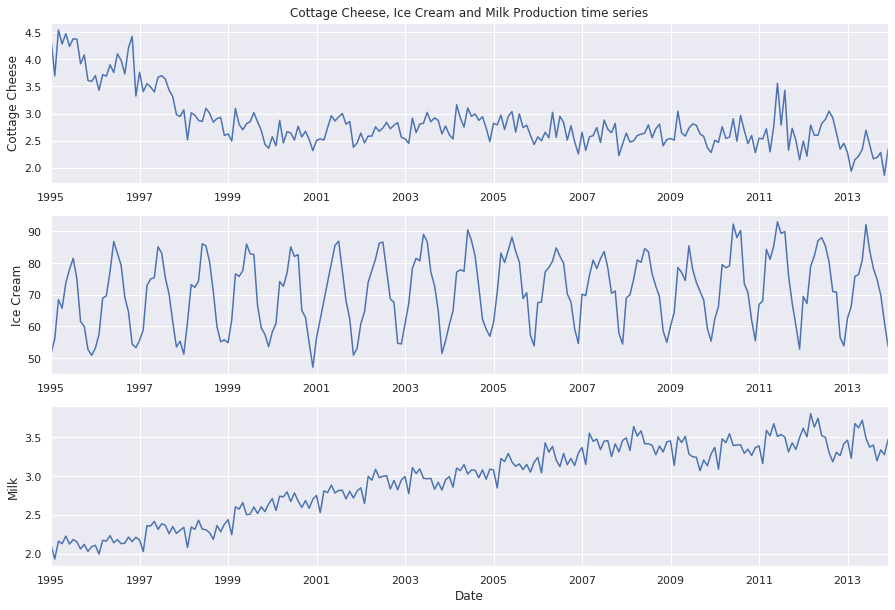

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
dairy_prod["Cotagecheese.Prod"].plot(ax = ax1)
dairy_prod["Icecream.Prod"].plot(ax = ax2)
dairy_prod["Milk.Prod"].plot(ax = ax3)
ax1.set_ylabel('Cottage Cheese')
ax2.set_ylabel('Ice Cream')
ax3.set_ylabel('Milk')
ax3.set_xlabel('Date')
ax1.set_title('Cottage Cheese, Ice Cream and Milk Production time series')

Milk production looks pretty interesting so let's run with that.

In [8]:
milk_ts = dairy_prod["Milk.Prod"]

### Step 1: Is the milk production time series stationary?

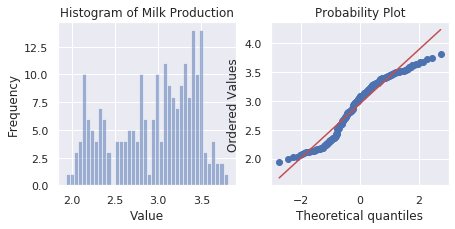

In [9]:
dist_ts(milk_ts, 'Milk Production')

**Conclusion**: By simply looking at the milk production time series above we can see that it's trending up so won't be a stationary time series. We can also take a quick look at the distribution of the values and see that the mean and variance aren't constant.

### Step 2: Is there a significant seasonal component to milk production?

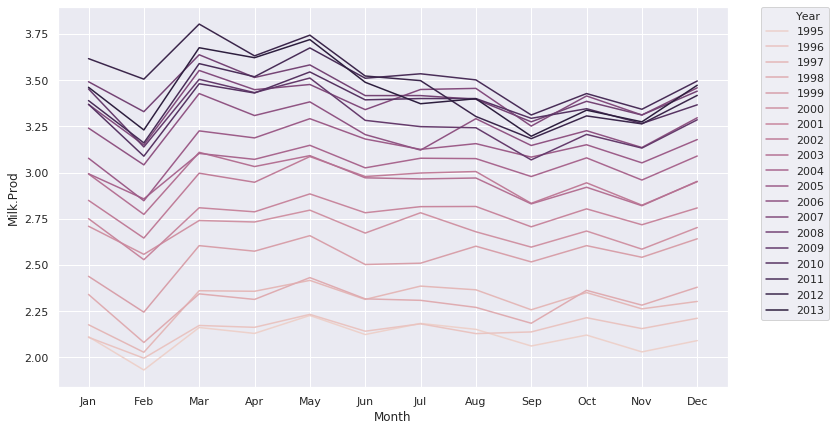

In [10]:
plt.figure(figsize=(12, 7))
ax = sns.lineplot(x="Month", y="Milk.Prod", hue="Year", sort=False, data=dairy_prod, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

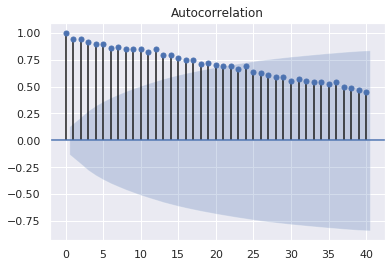

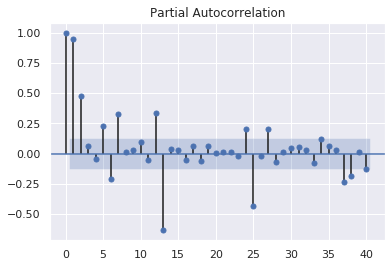

In [11]:
_=splt.plot_acf(milk_ts, lags = 40)
_=splt.plot_pacf(milk_ts, lags = 40)

**Conclusion**: Looking at the line plot by year and the ACF and PACF we see some cycling going on.


### Step 3: Perform STL decomposition 

We're going to use the additive model because while we did see cycles above there are not seasonal effect increases in proportion to the trend.

               resid     trend  seasonal
1995-01-31       NaN       NaN  0.027271
1995-02-28       NaN       NaN -0.179759
1995-03-31       NaN       NaN  0.144447
1995-04-30       NaN       NaN  0.079891
1995-05-31       NaN       NaN  0.163026
1995-06-30       NaN       NaN  0.011056
1995-07-31  0.053120  2.110458  0.020421
1995-08-31  0.035155  2.113000  0.003845
1995-09-30  0.065041  2.116125 -0.119166
1995-10-31  0.027444  2.117958 -0.024403
1995-11-30  0.028062  2.119583 -0.117646
1995-12-31 -0.020600  2.120583 -0.008984


,resid,trend,seasonal
2013-01-31,0.008687,3.426042,0.027271
2013-02-28,-0.014074,3.424833,-0.179759
2013-03-31,0.102178,3.429375,0.144447
2013-04-30,0.110900,3.431208,0.079891
2013-05-31,0.124016,3.432958,0.163026
2013-06-30,0.042236,3.435708,0.011056
2013-07-31,NaN,NaN,0.020421
2013-08-31,NaN,NaN,0.003845
2013-09-30,NaN,NaN,-0.119166
2013-10-31,NaN,NaN,-0.024403


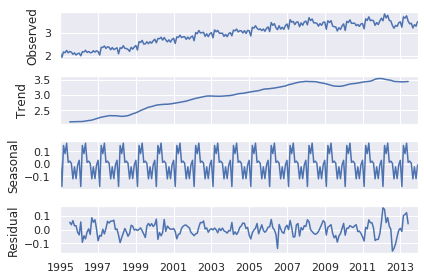

In [12]:
milk_decomp = decomp_ts(milk_ts, model='additive')
print(milk_decomp[:12])
milk_decomp[-12:]

#### Are the residuals stationary?

Now let's determine whether the residuals are stationary with the Dicky Fully test.

In [13]:
DF_Test(milk_decomp.resid[6:-6])

D-F statistic = -5.102729220342741
p-value = 1.3842923938680844e-05
number of lags used = 14
Critical value at 5% confidence = -2.876029332045744
Critical value at 10% confidence = -2.5744932593252643


**Conclusion**: Given the DF statistic and p-value we can reject the null hypothesis that the residuals are not stationary.    



### Step 4: Best Model Fit

In [14]:
milk_train_ts = milk_ts[:'2012-12-31']
best_model = pm.auto_arima(milk_train_ts, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             information_criterion = 'bic',
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize bic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-639.959, BIC=-623.393, Time=1.025 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-565.684, BIC=-559.058, Time=0.040 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-606.854, BIC=-593.601, Time=0.458 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-640.893, BIC=-627.640, Time=1.319 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-567.676, BIC=-564.363, Time=0.016 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-567.951, BIC=-558.011, Time=0.098 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-639.198, BIC=-622.632, Time=2.011 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=-639.393, BIC=-622.827, Time=2.070 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=-607.377, BIC=-594.124, Time=0.424 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=-636.948,

In [15]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  216
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 322.210
Date:                            Mon, 09 Mar 2020   AIC                           -638.421
Time:                                    05:20:29   BIC                           -628.481
Sample:                                         0   HQIC                          -634.399
                                            - 216                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.001     -0.377      0.706      -0.003       0.002
ma.S.L12      -0.7115      0.051    -14.025      0.000      -0.811      -0.612
sigma2         0.0023      0.000     13.411      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       52.06   Jarque-Bera (JB):                20.27
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.01
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Conclusion**: The best fitting model is SARIMAX(0, 1, 0)x(0, 1, 1, 12). Coefficents ma.S.L12 and sigma2 from the table above are satistically significant; they have values that fall within their confidence intervals.

### Step 5: Forecast the last 12 months.

In [16]:
prediction = pd.Series(best_model.predict(n_periods=12), 
                       index = pd.date_range(start = '2013-01-31', end = '2013-12-31', freq = 'M'))
prediction

2013-01-31    3.480619
2013-02-28    3.277386
2013-03-31    3.632533
2013-04-30    3.529474
2013-05-31    3.634812
2013-06-30    3.453382
2013-07-31    3.450386
2013-08-31    3.391238
2013-09-30    3.247856
2013-10-31    3.355694
2013-11-30    3.281339
2013-12-31    3.420590
Freq: M, dtype: float64

Text(0.5, 0, 'Date')

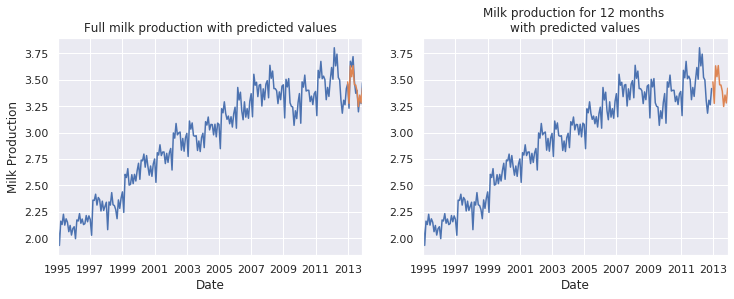

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
milk_ts.plot(ax=ax[0])
prediction.plot(ax=ax[0])
ax[0].set_title('Full milk production with predicted values')
ax[0].set_ylabel('Milk Production')
ax[0].set_xlabel('Date')

milk_train_ts.plot(ax=ax[1])
prediction.plot(ax=ax[1])
ax[1].set_title('Milk production for 12 months \nwith predicted values')
ax[1].set_xlabel('Date')

**Conclusion**: From graphical inspection I would say the predicted values are close to the actual ones.

### Step 6: Are the residuals approximately Normally distributed?

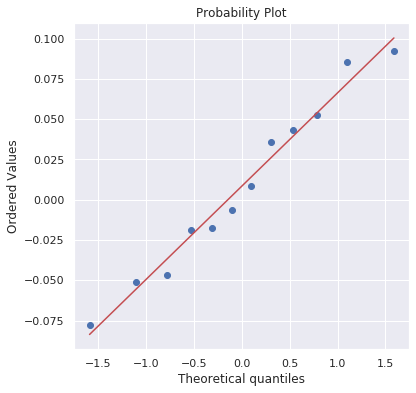

In [18]:
residuals = milk_ts['2013-01-31':] - prediction
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
_=ss.probplot(residuals, plot = ax)

**Conclusion**: The distribution of the residuals appears close to Normal. 

### Step 7: What is the RMSE? Is this value small relative to the forecasted values?

In [19]:
print(residuals)
print('\nThe STD of the residuals = {}'.format(np.round(np.std(residuals), 3)))

2013-01-31   -0.018619
2013-02-28   -0.046386
2013-03-31    0.043467
2013-04-30    0.092526
2013-05-31    0.085188
2013-06-30    0.035618
2013-07-31   -0.077386
2013-08-31    0.008762
2013-09-30   -0.050856
2013-10-31   -0.017694
2013-11-30   -0.006339
2013-12-31    0.052410
Freq: M, dtype: float64

The STD of the residuals = 0.052


**Conclusion**: The residuals and RMSE are small when compared to forecasted values.